In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('bmh')

In [2]:
import numpy as np

import ujson
import attr
import random
import torch

from glob import glob
from tqdm import tqdm_notebook
from itertools import islice
from boltons.iterutils import pairwise, chunked_iter
from collections import Counter

from gensim.models import KeyedVectors

from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import functional as F

In [3]:
vectors = KeyedVectors.load_word2vec_format(
    '../data/vectors/GoogleNews-vectors-negative300.bin.gz',
    binary=True,
)

In [110]:
class Corpus:
    
    def __init__(self, pattern, skim=None):
        self.pattern = pattern
        self.skim = skim
        
    def lines(self):
        for path in glob(self.pattern):
            with open(path) as fh:
                for line in fh:
                    yield line.strip()

    def abstracts(self):
        lines = self.lines()
        if self.skim:
            lines = islice(lines, self.skim)
        for line in tqdm_notebook(lines, total=self.skim):
            raw = ujson.loads(line)
            yield Abstract.from_raw(raw)
            
    def xy(self):
        for ab in self.abstracts():
            yield ab.tensor(), torch.FloatTensor([1])
            yield ab.tensor(shuffle=True), torch.FloatTensor([0])

In [111]:
@attr.s
class Abstract:
    
    sentences = attr.ib()
    
    @classmethod
    def from_raw(cls, raw):
        return cls([Sentence(s['token']) for s in raw['sentences']])
    
    def shuffled_sentences(self):
        return sorted(self.sentences, key=lambda s: random.random())
    
    def tensor(self, shuffle=False, dim=300, pad=200):
        sents = self.shuffled_sentences() if shuffle else self.sentences
        x = [vectors[t] for s in sents for t in s.tokens if t in vectors]
        x += [np.zeros(dim)] * pad
        x = x[:pad]
        x = list(reversed(x))
        x = np.array(x)
        x = torch.from_numpy(x)
        x = x.float()
        return x

In [224]:
class Model(nn.Module):
    
    def __init__(self, embed_dim=300, lstm_dim=64, lin_dim=64):
        super().__init__()
        self.lstm_dim = lstm_dim
        self.lstm = nn.LSTM(embed_dim, lstm_dim, batch_first=True)
        self.lin1 = nn.Linear(lstm_dim, lin_dim)
        self.lin2 = nn.Linear(lin_dim, lin_dim)
        self.lin3 = nn.Linear(lin_dim, lin_dim)
        self.out = nn.Linear(lin_dim, 1)
        
    def forward(self, x):
        h0 = Variable(torch.zeros(1, len(x), self.lstm_dim))
        c0 = Variable(torch.zeros(1, len(x), self.lstm_dim))
        _, (hn, cn) = self.lstm(x, (h0, c0))
        y = F.sigmoid(self.out(hn))
        return y.view(len(x))

In [225]:
train = Corpus('../data/train.json/*.json', 10000)

In [226]:
loader = DataLoader(list(train.xy()), 32)

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

In [227]:
torch.manual_seed(1)
model = Model()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [228]:
train_loss = []
for epoch in range(20):
    
    print(f'Epoch {epoch}')
    
    epoch_loss = 0
    for x, y in tqdm_notebook(loader):

        x = Variable(x)
        y = Variable(y.view(-1))

        model.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)
        loss.backward()

        optimizer.step()
        
        epoch_loss += loss.data[0]
        
    epoch_loss /= len(loader)
    train_loss.append(epoch_loss)
    print(epoch_loss)

Epoch 0


HBox(children=(IntProgress(value=0, max=625), HTML(value='')))


0.5776079555511474
Epoch 1


HBox(children=(IntProgress(value=0, max=625), HTML(value='')))


0.5283992784023285
Epoch 2


HBox(children=(IntProgress(value=0, max=625), HTML(value='')))


0.5038549181461334
Epoch 3


HBox(children=(IntProgress(value=0, max=625), HTML(value='')))


0.47930165579319
Epoch 4


HBox(children=(IntProgress(value=0, max=625), HTML(value='')))


0.45659306626319884
Epoch 5


HBox(children=(IntProgress(value=0, max=625), HTML(value='')))


0.43553189539909365
Epoch 6


HBox(children=(IntProgress(value=0, max=625), HTML(value='')))


0.4208972008943558
Epoch 7


HBox(children=(IntProgress(value=0, max=625), HTML(value='')))


0.39739184694290164
Epoch 8


HBox(children=(IntProgress(value=0, max=625), HTML(value='')))


0.3809551627397537
Epoch 9


HBox(children=(IntProgress(value=0, max=625), HTML(value='')))


0.3550604962348938
Epoch 10


HBox(children=(IntProgress(value=0, max=625), HTML(value='')))


0.33659231693744657
Epoch 11


HBox(children=(IntProgress(value=0, max=625), HTML(value='')))


0.3211584890365601
Epoch 12


HBox(children=(IntProgress(value=0, max=625), HTML(value='')))


0.30077781977653506
Epoch 13


HBox(children=(IntProgress(value=0, max=625), HTML(value='')))


0.28842020090818404
Epoch 14


HBox(children=(IntProgress(value=0, max=625), HTML(value='')))


0.27428922560214997
Epoch 15


HBox(children=(IntProgress(value=0, max=625), HTML(value='')))


0.2678484926044941
Epoch 16


HBox(children=(IntProgress(value=0, max=625), HTML(value='')))


0.2422297322034836
Epoch 17


HBox(children=(IntProgress(value=0, max=625), HTML(value='')))


0.23124313837587834
Epoch 18


HBox(children=(IntProgress(value=0, max=625), HTML(value='')))


0.2229310537159443
Epoch 19


HBox(children=(IntProgress(value=0, max=625), HTML(value='')))


0.20666147934198378


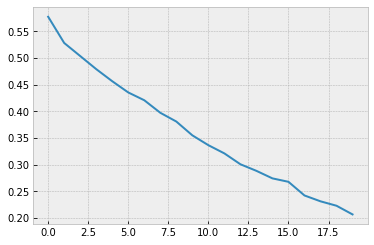

In [229]:
plt.plot(train_loss)

In [234]:
dev = Corpus('../data/dev.json/*.json', 2000)

In [235]:
dev_loader = DataLoader(list(dev.xy()), 100)

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

In [244]:
c = Counter()
t = Counter()

abstracts = dev.abstracts()

for xyp in chunked_iter(dev.xy(), 2):
    
    ab = next(abstracts)
    
    for x, y in xyp:
    
        x = Variable(x.unsqueeze(0))
        y = Variable(y)

        y_pred = model(x)

        if y_pred.round().data[0] == y.data[0]:
            c[len(ab.sentences)] += 1

        t[len(ab.sentences)] += 1

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Exception in thread Thread-126:
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/dclure/Projects/plot-ordering/env/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/local/bin/../Cellar/python3/3.6.2/bin/../Frameworks/Python.framework/Versions/3.6/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [245]:
for slen in sorted(c.keys()):
    print(slen, c[slen] / t[slen])

2 0.6336898395721925
3 0.6893203883495146
4 0.748587570621469
5 0.7621082621082621
6 0.7679324894514767
7 0.7860696517412935
8 0.7346153846153847
9 0.8426966292134831
10 0.7686567164179104
11 0.8548387096774194
12 0.782608695652174
13 0.75
14 0.9166666666666666
15 0.8
16 1.0


In [243]:
sum(c.values()) / sum(t.values())

0.7325